
# Introduction to Classification.

    Notebook version: 2.4 (Sep 17, 2024)

    Author: Jesús Cid Sueiro (jcid@tsc.uc3m.es)
            Jerónimo Arenas García (jarenas@tsc.uc3m.es)
            
    Changes: v.1.0 - First version. Extracted from a former notebook on K-NN
             v.2.0 - Adapted to Python 3.0 (backcompatible with Python 2.7)
             v.2.1 - Minor corrections affecting the notation and assumptions
             v.2.2 - Updated index notation
             v.2.3 - Adaptation to slides conversion
             v.2.4 - (JCS) Use of pandas. Updated python code.

In [1]:
%matplotlib inline 

# Import some libraries that will be necessary for working with data and displaying plots
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## 1. The Classification problem

In a generic classification problem, we are given an **observation vector** ${\bf x}\in \mathbb{R}^N$ which is known to belong to one and only one **category** or **class**, $y$, from the set ${\mathcal Y} = \{0, 1, \ldots, M-1\}$. 

The goal of a classifier system is to **predict** $y$ based on ${\bf x}$.

To design the classifier, we are given a collection of labelled observations ${\mathcal D} = \{({\bf x}_k, y_k)\}_{k=0}^{K-1}$ where, for each observation ${\bf x}_k$, the value of its true category, $y_k$, is known.

### 1.1. Binary Classification

We will focus mostly in binary classification problems, where the label set is binary, ${\mathcal Y} = \{0, 1\}$. 

Despite its simplicity, this is the most frequent case. Many multi-class classification problems are usually solved by decomposing them into a collection of binary problems.

### 1.2. The independence and identical distribution (i.i.d.) assumption.

The classification algorithms, as many other machine learning algorithms, are based on two major underlying hypothesis:

   - **Independence**: All samples are statistically independent.
   - **Identical distribution**: All samples in dataset ${\mathcal D}$ have been generated by the same distribution $p_{{\bf X}, Y}({\bf x}, y)$.
   
The i.i.d. assumption is essential to guarantee that a classifier based on ${\mathcal D}$ has a good perfomance when applied to new input samples. 

The **underlying distribution is unknown** (if we knew it, we could apply classic decision theory to make optimal predictions). This is why we need the data in ${\mathcal D}$ to design the classifier. 


## 2. A simple classification problem: the Iris dataset

(Iris dataset presentation is based on this <a href=http://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/> Tutorial </a> by <a href=http://machinelearningmastery.com/about/> Jason Brownlee</a>) 

As an illustration, consider the <a href = http://archive.ics.uci.edu/ml/datasets/Iris> Iris dataset </a>, taken from the <a href=http://archive.ics.uci.edu/ml/> UCI Machine Learning repository </a>. Quoted from the dataset description:

> *This is perhaps the best known database to be found in the pattern recognition literature. The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant. [...] One class is linearly separable from the other 2; the latter are NOT linearly separable from each other.* 

The *class* is the species, which is one of *setosa*, *versicolor* or *virginica*. Each instance contains 4 measurements of given flowers: sepal length, sepal width, petal length and petal width, all in centimeters.  The last column shows the class of each instance.

In [2]:
df_data = pd.read_csv('datasets/iris.data', header=None)
df_data.head(10)

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


We can inspect some basic statistics of the data features using the `describe` method from the `pandas` package.

In [3]:
df_data.describe()

,0,1,2,3
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


We will separate the features and the target categories into a feature matrix and a list of class labels. Labels will be mapped to integers to facilitate the treatment.

In [4]:
# Extract the features and the classes from the dataframe
X = df_data.iloc[:, 0:4].values
C = df_data.iloc[:, 4].values

# Map the classes to integers
Y = LabelEncoder().fit_transform(C)
# Get a dictionary mapping from integers to classes
int_to_class = dict(zip(Y, C))
print(int_to_class)
# Get a dictionary mapping from classes to integers
class_to_int = dict(zip(C, Y))

n_clases = len(int_to_class)
n_samples, n_features = X.shape

# Show the data dimensions:
print(f"-- The feature matrix contains {n_samples} samples and {n_features} features.")

# Pretty print the mapping
print("-- The following mapping from integers to classes will be used:")
for k, v in int_to_class.items():
    print(f"     {k} -> {v}")


{np.int64(0): 'Iris-setosa', np.int64(1): 'Iris-versicolor', np.int64(2): 'Iris-virginica'}
-- The feature matrix contains 150 samples and 4 features.
-- The following mapping from integers to classes will be used:
     0 -> Iris-setosa
     1 -> Iris-versicolor
     2 -> Iris-virginica


###  2.1. Training and test

Next, we will split the data into two sets:

* **Training set**, that will be used to learn the classification model
* **Test set**, that will be used to evaluate the classification performance

To make the partition, we can use the `train_test_split` method from `sklearn`.

In [5]:
# Split the dataset into training and testing sets
X_trn_all, X_tst_all, Y_trn_all, Y_tst_all = train_test_split(
    X, Y, test_size=0.33, random_state=42)

# Dataset sizes
n_trn = len(Y_trn_all)
n_tst = len(Y_tst_all)

# Show the data dimensions:
print(f"-- {n_trn} training samples.")
print(f"-- {n_tst} test samples.")


-- 100 training samples.
-- 50 test samples.


### 2.2. Scatter plots

To get some intuition about this four dimensional dataset we can plot 2-dimensional projections taking only two variables each time.

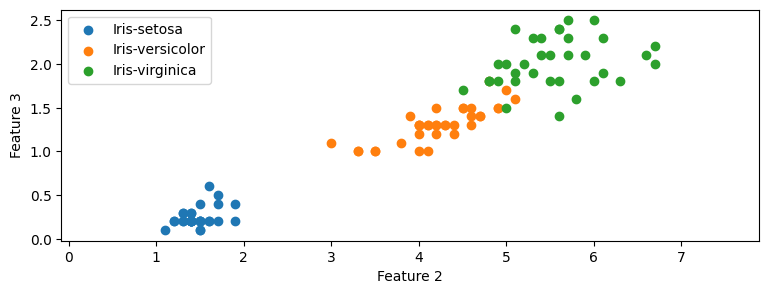

In [6]:
fh = 2  # First feature to plot
fv = 3  # Second feature to plot

plt.figure(figsize=(9, 3))
for i in range(n_clases):
    # Plot the samples of class i
    plt.scatter(X_trn_all[Y_trn_all == i, fh], X_trn_all[Y_trn_all == i, fv],
                label=int_to_class[i])
plt.axis('equal')
plt.xlabel(f'Feature {fh}')
plt.ylabel(f'Feature {fv}')
plt.legend()
plt.show()


In the following, we will design a classifier to separate classes "Versicolor" and "Virginica" using $x_0$ and $x_1$ only. To do so, we build a training set with samples from these categories, and a binary label $y^{(k)} = 1$ for samples in class "Virginica", and $0$ for "Versicolor" data.

In [7]:
# Select two classes
ignored_class = 'Iris-setosa'
c0 = 'Iris-versicolor' 
c1 = 'Iris-virginica'
# Select two features
ind = [0, 1]

# New map indices to classes
int_to_class_2 = {0: c0, 1: c1}
class_to_int_2 = {c0: 0, c1: 1}

# Select samples
X_trn = X_trn_all[Y_trn_all != class_to_int[ignored_class], ]
X_tst = X_tst_all[Y_tst_all != class_to_int[ignored_class], :]
# Select features
X_trn = X_trn[:, ind]
X_tst = X_tst[:, ind]

# Select labels for the selected features
Y_trn = Y_trn_all[Y_trn_all != class_to_int[ignored_class]]
Y_tst = Y_tst_all[Y_tst_all != class_to_int[ignored_class]]

# Map to new class indices
Y_trn = Y_trn == class_to_int[c1]
Y_tst = Y_tst == class_to_int[c1]

# Dataset sizes
n_trn = len(Y_trn)
n_tst = len(Y_tst)
# Show the data dimensions:
print(f"-- {n_trn} training samples.")
print(f"-- {n_tst} test samples.")


-- 69 training samples.
-- 31 test samples.


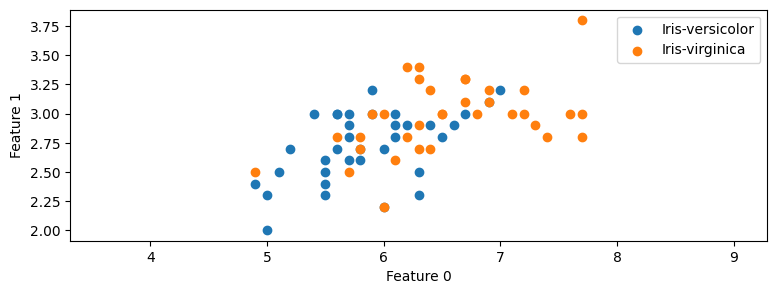

In [8]:
plt.figure(figsize=(9, 3))
for i in [0, 1]:
    # Plot the samples of class i
    plt.scatter(X_trn[Y_trn == i, 0], X_trn[Y_trn == i, 1],
                label=int_to_class_2[i])
plt.axis('equal')
plt.xlabel(f'Feature {ind[0]}')
plt.ylabel(f'Feature {ind[1]}')
plt.legend()
plt.show()

## 3. A Baseline Classifier: Maximum A Priori.

For the selected data set, we have two clases and a dataset with the following class proportions:

In [9]:
print(f'Class 0 ({c0}): {n_trn - sum(Y_trn)} samples')
print(f'Class 1 ({c1}): {sum(Y_trn)} samples')

Class 0 (Iris-versicolor): 35 samples
Class 1 (Iris-virginica): 34 samples


The maximum a priori classifier assigns any sample ${\bf x}$ to the most frequent class in the training set. Therefore, the class prediction $y$ for any sample ${\bf x}$ is

In [10]:
y = int(2*sum(Y_trn) > n_trn)
print(f'y = {y} ({c1 if y==1 else c0})')

y = 0 (Iris-versicolor)


The error rate for this baseline classifier is:

In [11]:
# Training and test error arrays
E_trn = (Y_trn != y)
E_tst = (Y_tst != y)

# Error rates
pe_trn = float(sum(E_trn)) / n_trn
pe_tst = float(sum(E_tst)) / n_tst
print('Pe(train):', str(pe_trn))
print('Pe(test): ', str(pe_tst))

Pe(train): 0.4927536231884058
Pe(test):  0.5161290322580645


The error rate of the baseline classifier is a simple benchmark for classification. Since the maximum a priori decision is independent on the observation, ${\bf x}$, any classifier based on ${\bf x}$ should have a better (or, at least, not worse) performance than the baseline classifier.

## 3. Parametric vs non-parametric classification.

Most classification algorithms can be fitted to one of two categories:

1. **Parametric classifiers**: to classify any input sample ${\bf x}$, the classifier applies some function $f_{\bf w}({\bf x})$ which depends on some parameters ${\bf w}$. The training dataset is used to estimate ${\bf w}$. Once the parameter has been estimated, the training data is no longer needed to classify new inputs.

2. **Non-parametric classifiers**: the classifier decision for any input ${\bf x}$ depend on the training data in a direct manner. The training data must be preserved to classify new data.

